# 实验

In [2]:
import numpy as np
import os
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image
import cv2
%matplotlib inline

/Users/hoijanlai/.pyenv/versions/3.6.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# 模型路径

In [2]:
PATH_TO_CKPT = os.path.join('graph_ok', 'frozen_inference_graph.pb')
PATH_TO_LABELS = 'car_label_map.pbtxt'
NUM_CLASSES = 1

## 载入模型

In [3]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## 辅助

In [4]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

## 抽取若干样本图片

In [5]:
PATH_TO_TEST_IMAGES_DIR = 'test'
PATH_TO_TEST_IMAGES_DIR = './TSD-Vehicle/TSD-Vehicle-00068'
TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, im) for im in os.listdir(PATH_TO_TEST_IMAGES_DIR) if '.png' in im]
IMAGE_SIZE = (24, 20)

# 计算图端提取

In [6]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    

## 计算图流动

(1024, 1280, 3)


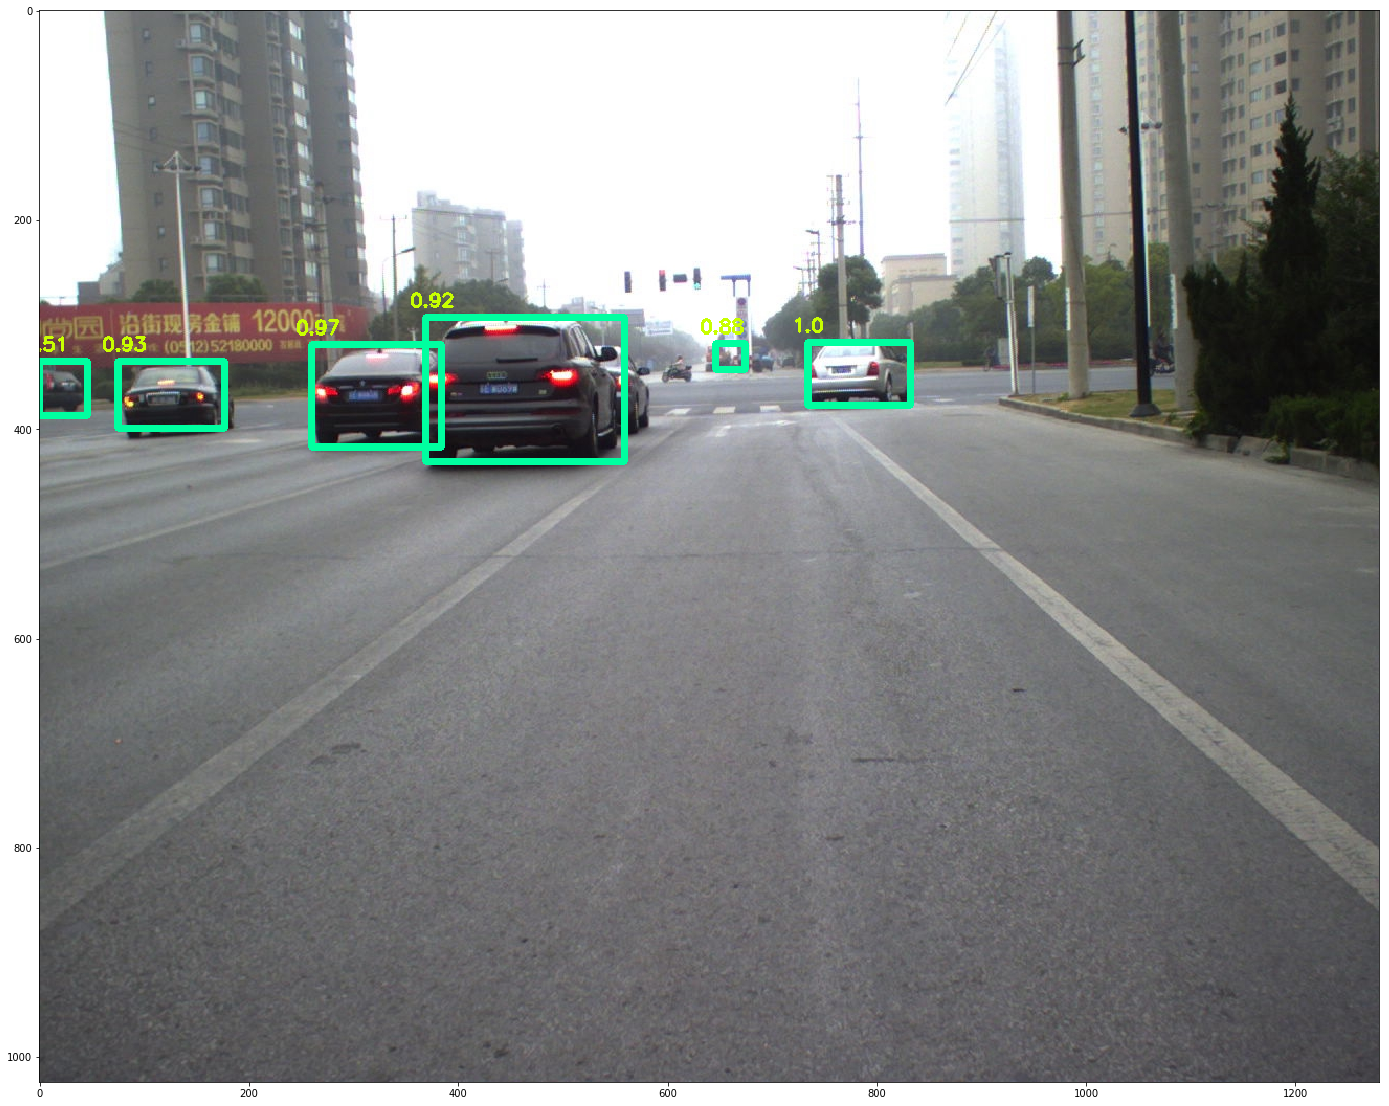

(1024, 1280, 3)


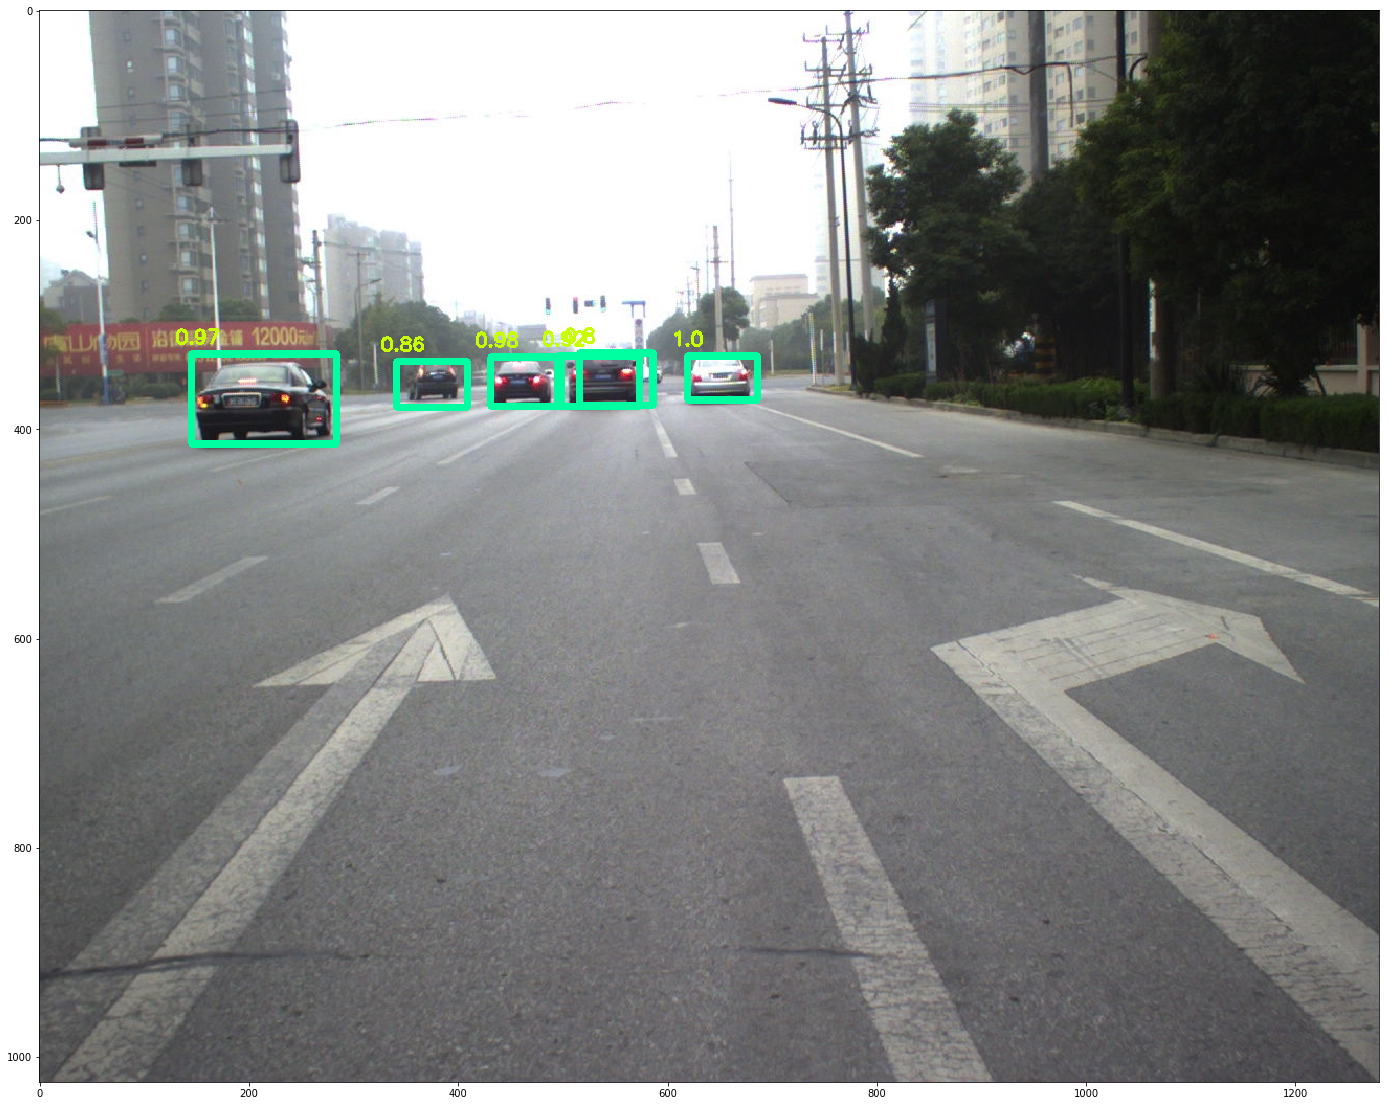

In [7]:
THRESHOLD = 0.5 
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:    
        for image_path in TEST_IMAGE_PATHS[:2]:
            image = Image.open(image_path)
            
            image_np = load_image_into_numpy_array(image)
            
            image_np_expanded = np.expand_dims(image_np, axis=0)
            
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
        
            indexes = np.where(scores.flatten()>0.5)
            scores = scores.flatten()[indexes]
            boxes = np.reshape(boxes, boxes.shape[1:])[indexes]
     
            w, h = image.size
            print(image_np.shape)
            for box in boxes:
                cv2.rectangle(image_np, (int(box[1]*w), int(box[0]*h)), (int(box[3]*w), int(box[2]*h)), color=(0, 255, 160), thickness=5)
            for score, box in zip(scores, boxes):
                cv2.putText(image_np, str(round(score, 2)), (int(box[1]*w)-15, int(box[0]*h)-10), 0, 0.6, (200, 255, 0), 2)
            
            
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()
        

In [8]:
from lxml import etree


real_box = lambda box, w, h : (int(box[1]*w), int(box[0]*h), int(box[3]*w)-int(box[1]*w), int(box[2]*h)-int(box[0]*h))


def append_frame(root, boxes, frame_id, frame_size):
    num_target = len(boxes)
    frame_item = etree.Element('Frame%sTargetNumber'%frame_id)
    frame_item.text = str(num_target)
    root.append(frame_item)
    w, h = frame_size
    for k, box in enumerate(boxes):
        child = etree.Element('Frame%sTarget%0.5d'%(frame_id, k))
        pos = etree.Element('Position')
        pos.text = '%d %d %d %d'%real_box(box, w, h)
        child.append(pos)
        root.append(child)
    return root


def video_to_frames(video):
    return frames


def frame_to_array(frame):
    # TODO 补全这个函数
    return frame

In [9]:
def predict_and_write(image_file_names, set_name, sess):
    root = etree.Element('opencv_storage')
    for image_path in tqdm(TEST_IMAGE_PATHS):
        # 读取
        image = Image.open(image_path)
        image_np = load_image_into_numpy_array(image)
        image_np_expanded = np.expand_dims(image_np, axis=0)

        # 预测
        (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})

        # 解析
        indexes = np.where(scores.flatten()>0.5)
        scores = scores.flatten()[indexes]
        boxes = np.reshape(boxes, boxes.shape[1:])[indexes]

        # 录入
        h, w = image_np.shape[:2]
        frame_id = image_path[-9:-4] 
        root = append_frame(root, boxes, frame_id, (w, h))


    # print(write_xml(boxes, 0, image.size, root).decode('utf-8'))
    # etree.tostring(root, pretty_print=True, encoding="gbk")
    open('TSD-Vehicle-%s-Result.xml'%set_name, 'w').writelines(etree.tostring(root, pretty_print=True, encoding="gbk").decode("gbk"))
    lines = open('TSD-Vehicle-%s-Result.xml'%set_name, 'r').readlines()
    lines[0] = lines[0].replace('\'', '"')
    open('TSD-Vehicle-%s-Result.xml'%set_name, 'w').writelines(lines)

In [13]:
# TSD-Vehicle
#  -TSD-Vehicle-xxxxx
#      -.pngs
# TSD-Vehicle-GT
#  -.xml
from tqdm import tqdm
import glob

RESULT_FOLDER = "TSD-Vehicle-Result-上海Cargo"

image_folder_names = glob.glob("TSD-Vehicle/*")
#print(" ".join(image_folder_names))
set_names = []
for name in image_folder_names:
    #print(name)
    if name[-3:] != "png":
        set_names.append(name[-5:])
        
# debug
set_names = set_names[6]

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess: 
        
        for set_name in set_names:

            image_file_names = glob.glob("TSD-Vehicle/TSD-Vehicle-%s/*.png"%(set_name))

            predict_and_write(image_file_names, set_name, sess)


NameError: name 'detection_graph' is not defined

In [12]:
TEST_IMAGE_PATHS

['./TSD-Vehicle/TSD-Vehicle-00068/TSD-Vehicle-00068-00039.png',
 './TSD-Vehicle/TSD-Vehicle-00068/TSD-Vehicle-00068-00005.png',
 './TSD-Vehicle/TSD-Vehicle-00068/TSD-Vehicle-00068-00011.png',
 './TSD-Vehicle/TSD-Vehicle-00068/TSD-Vehicle-00068-00010.png',
 './TSD-Vehicle/TSD-Vehicle-00068/TSD-Vehicle-00068-00004.png',
 './TSD-Vehicle/TSD-Vehicle-00068/TSD-Vehicle-00068-00038.png',
 './TSD-Vehicle/TSD-Vehicle-00068/TSD-Vehicle-00068-00012.png',
 './TSD-Vehicle/TSD-Vehicle-00068/TSD-Vehicle-00068-00006.png',
 './TSD-Vehicle/TSD-Vehicle-00068/TSD-Vehicle-00068-00007.png',
 './TSD-Vehicle/TSD-Vehicle-00068/TSD-Vehicle-00068-00013.png',
 './TSD-Vehicle/TSD-Vehicle-00068/TSD-Vehicle-00068-00017.png',
 './TSD-Vehicle/TSD-Vehicle-00068/TSD-Vehicle-00068-00003.png',
 './TSD-Vehicle/TSD-Vehicle-00068/TSD-Vehicle-00068-00002.png',
 './TSD-Vehicle/TSD-Vehicle-00068/TSD-Vehicle-00068-00016.png',
 './TSD-Vehicle/TSD-Vehicle-00068/TSD-Vehicle-00068-00000.png',
 './TSD-Vehicle/TSD-Vehicle-00068/TSD-Ve

In [13]:
# print(TEST_IMAGE_PATHS)

# 文件名样例 : TSD-Vehicle-00068-00000.png
# 文件名样例 : TSD-Vehicle-00068-GT.xml
# 输出文件名样例 : TSD-Vehicle-00068-Result.xml


root = etree.Element('opencv_storage')
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess: 
        for image_path in tqdm(TEST_IMAGE_PATHS):
            # 读取
            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)
            image_np_expanded = np.expand_dims(image_np, axis=0)
            
            # 预测
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
        
            # 解析
            indexes = np.where(scores.flatten()>0.5)
            scores = scores.flatten()[indexes]
            boxes = np.reshape(boxes, boxes.shape[1:])[indexes]
            
            # 录入
            h, w = image_np.shape[:2]
            frame_id = image_path[-9:-4] 
            root = append_frame(root, boxes, frame_id, (w, h))


# print(write_xml(boxes, 0, image.size, root).decode('utf-8'))
# etree.tostring(root, pretty_print=True, encoding="gbk")
open('TSD-Vehicle-00068-Result.xml', 'w').writelines(etree.tostring(root, pretty_print=True, encoding="gbk").decode("gbk"))


  0%|          | 0/58 [00:00<?, ?it/s]
Exception in thread Thread-10:
Traceback (most recent call last):
  File "/Users/hoijanlai/.pyenv/versions/3.6.0/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/hoijanlai/.pyenv/versions/playground/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/hoijanlai/.pyenv/versions/3.6.0/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 58/58 [01:21<00:00,  1.41s/it]


In [53]:
lines = open('TSD-Vehicle-00068-Result.xml', 'r').readlines()
lines[0] = lines[0].replace('\'', '"')
open('TSD-Vehicle-00068-Result.xml', 'w').writelines(lines)

In [54]:
open('TSD-Vehicle-00068-Result.xml', 'w').writelines(lines)

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00058.png


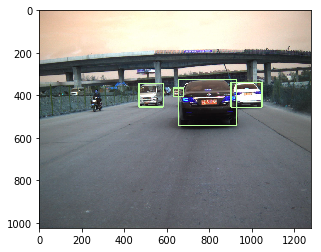

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00064.png


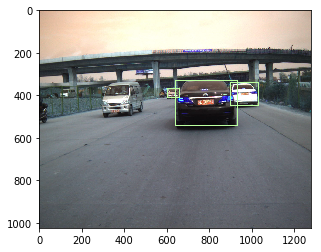

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00070.png


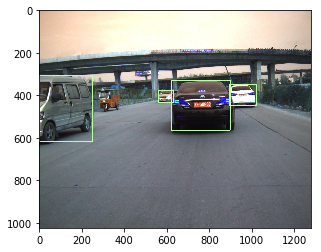

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00071.png


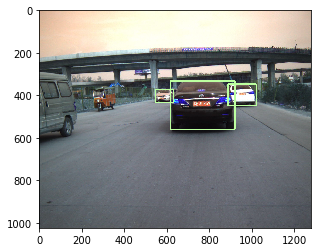

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00065.png


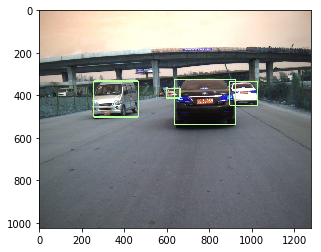

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00059.png


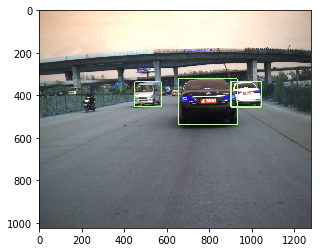

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00073.png


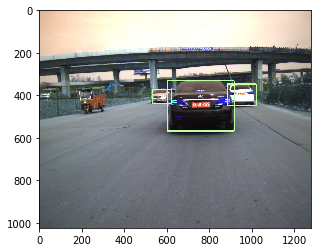

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00067.png


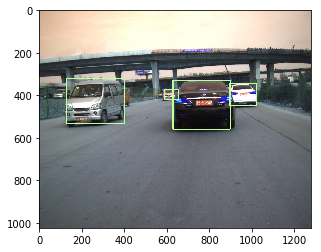

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00066.png


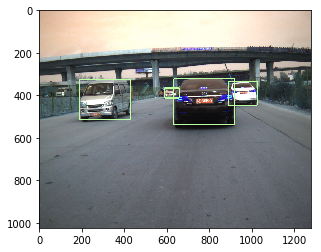

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00072.png


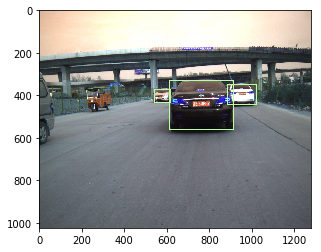

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00076.png


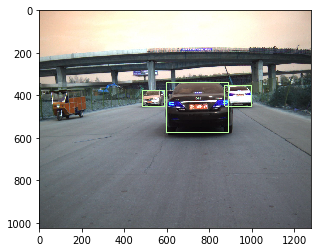

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00062.png


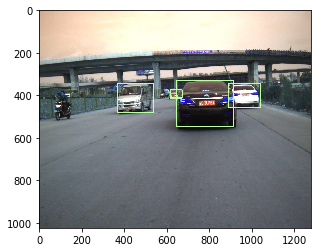

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00063.png


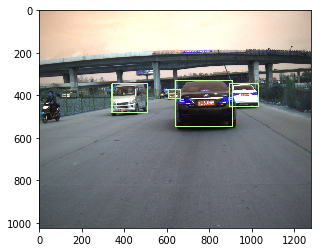

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00077.png


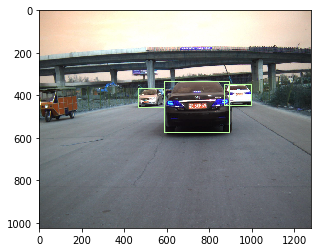

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00061.png


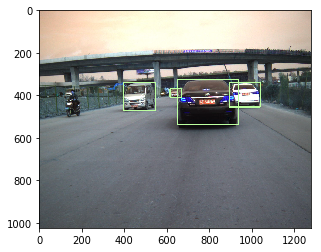

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00075.png


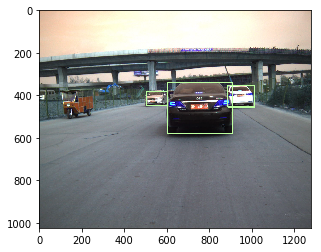

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00049.png


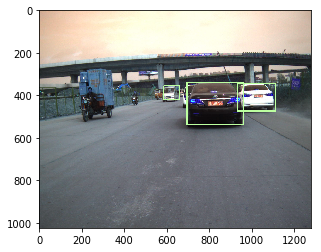

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00048.png


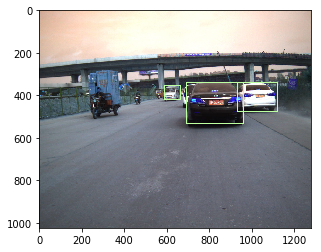

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00074.png


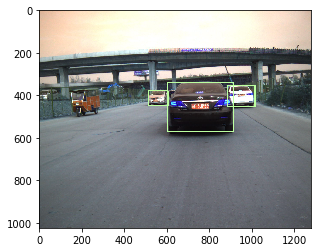

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00060.png


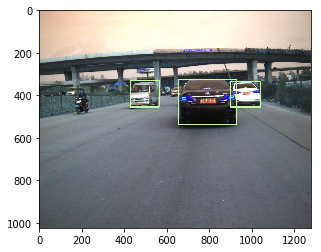

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00007.png


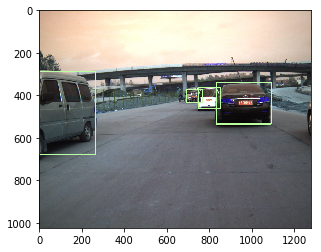

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00013.png


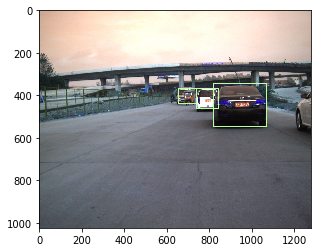

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00012.png


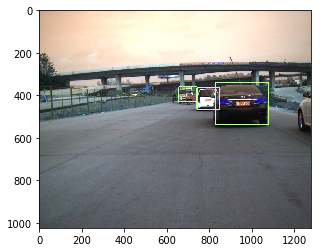

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00006.png


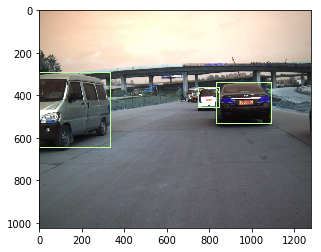

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00038.png


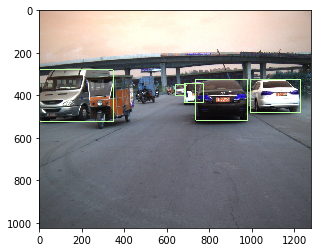

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00010.png


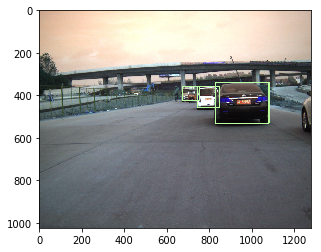

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00004.png


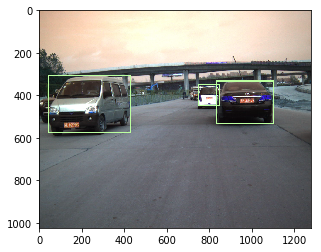

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00005.png


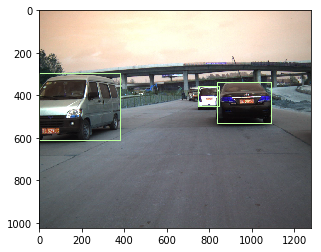

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00011.png


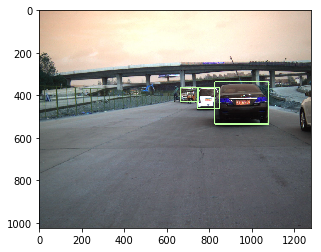

./TSD-Vehicle/TSD-Vehicle-00103/TSD-Vehicle-00103-00039.png


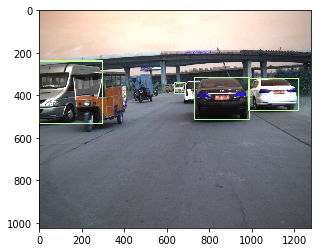

In [17]:
import xml.etree.ElementTree as ET
import re

findNumber = lambda x : [int(k) for k in re.findall(r'\d+', x)]

official = './TSD-Vehicle/TSD-Vehicle-00103'
# official_xml = './TSD-Vehicle-GT/TSD-Vehicle-00068-GT.xml'

my_xml = 'TSD-Vehicle-00103-Result.xml'



pngs = list(filter(lambda x : 'png' in x, os.listdir(official)))


sample_root = ET.parse(my_xml).getroot()
items = sample_root.getchildren()
num_frames = 30
frames = items

idx = 0
for _ in range(num_frames):
    frame_num = re.findall(r'\d+', frames[idx].tag)[0] 
    frame_path = os.path.join(official, my_xml[:-11]+'-%s.png'%frame_num)
    print(frame_path)
    num_target = int(frames[idx].text)
    frame_img = cv2.imread(frame_path)
    h, w = frame_img.shape[:2]
    record = ''

    for k in range(num_target):
        
        # 
        rect = findNumber(frames[idx+k+1].getchildren()[0].text)
        xmin, ymin, xmax, ymax = rect[0], rect[1], rect[0] + rect[2], rect[1] + rect[3]
        cv2.rectangle(frame_img, (xmin, ymin), (xmax, ymax), color=(188, 255, 160), thickness=3)
        #
        
        
    plt.imshow(frame_img)
    plt.show()

    idx = idx + num_target + 1




In [57]:




# target 样例 (target_id, track_id, dist)
#            (int, int, float)
def append_frame_targets_dists(root, frame_id, targets):
    for i, target in enumerate(targets):
        target_id, track_id, dist = target
        item = etree.Element("Frame%sTarget%0.5d"%(frame_id, i))
        
        id_stuff = etree.Element("ID")
        id_stuff.text = str(track_id)
        
        dist_stuff = etree.Element("Distance")
        dist_stuff.text = "%f"%dist
        
        
        item.append(id_stuff)
        item.append(dist_stuff)
        
        root.append(item)
    return root



root = etree.Element('opencv_storage')

# 写一个两帧, 每帧三个目标的 tree
frames = ["00000", "00001"]

all_targets = [[(1, 1, 16.888888), (0, 3, 6.888888), (2, 2, 26.888888)],
           [(1, 1, 16.888888), (0, 2, 16.888888), (2, 3, 8.888888)]]

for frame, targets in zip(frames, all_targets):
    root = append_frame_targets_dists(root, frame, targets)

open('TSD-FVDM-00068-Result.xml', 'w').writelines(etree.tostring(root, pretty_print=True, encoding="gbk").decode("gbk"))  
    